# new definition of state

### +1 for increasing
### 0 for invariable
### -1 for decreasing

In [10]:
rsrp_trend = [0]
buffer_trend = [0, -1]
avg_trend = [1, 0, -1]
cqi_trend = [1, 0, -1]

In [1]:
from treelib import Node, Tree
import numpy as np

In [2]:
tree = Tree()
node_rsrp = Node(tag='RSRP', identifier='rsrp', data=0)
tree.add_node(node_rsrp)  # root node

node_buffer = [
    Node(tag='buffer_-1', identifier='buffer_-1', data=-1),
    Node(tag='buffer_0', identifier='buffer_0', data=0)
]
for node in node_buffer:
    tree.add_node(node, parent='rsrp')
    
for parent_id in ['buffer_0', 'buffer_-1']:
    tree.create_node(tag='avg_-1', identifier=parent_id+'avg_-1', data=-1, parent=parent_id)
    tree.create_node(tag='avg_0', identifier=parent_id+'avg_0', data=0, parent=parent_id)
    tree.create_node(tag='avg_1', identifier=parent_id+'avg_1', data=1, parent=parent_id) 

for parent_id in ['buffer_0', 'buffer_-1']:
    for parent_idd in ['avg_-1', 'avg_0', 'avg_1']:
        tree.create_node(tag='cqi_-1', identifier=parent_id+parent_idd+'cqi_-1', data=-1, parent=parent_id+parent_idd)
        tree.create_node(tag='cqi_0', identifier=parent_id+parent_idd+'cqi_0', data=0, parent=parent_id+parent_idd)
        tree.create_node(tag='cqi_1', identifier=parent_id+parent_idd+'cqi_1', data=1, parent=parent_id+parent_idd)

In [3]:
tree.show()
paths = tree.paths_to_leaves()

for i in range(len(paths)):
    for j in range(4):
        paths[i][j] = tree.nodes[paths[i][j]].data
paths

RSRP
├── buffer_-1
│   ├── avg_-1
│   │   ├── cqi_-1
│   │   ├── cqi_0
│   │   └── cqi_1
│   ├── avg_0
│   │   ├── cqi_-1
│   │   ├── cqi_0
│   │   └── cqi_1
│   └── avg_1
│       ├── cqi_-1
│       ├── cqi_0
│       └── cqi_1
└── buffer_0
    ├── avg_-1
    │   ├── cqi_-1
    │   ├── cqi_0
    │   └── cqi_1
    ├── avg_0
    │   ├── cqi_-1
    │   ├── cqi_0
    │   └── cqi_1
    └── avg_1
        ├── cqi_-1
        ├── cqi_0
        └── cqi_1



[[0, 0, -1, -1],
 [0, 0, -1, 0],
 [0, 0, -1, 1],
 [0, 0, 0, -1],
 [0, 0, 0, 0],
 [0, 0, 0, 1],
 [0, 0, 1, -1],
 [0, 0, 1, 0],
 [0, 0, 1, 1],
 [0, -1, -1, -1],
 [0, -1, -1, 0],
 [0, -1, -1, 1],
 [0, -1, 0, -1],
 [0, -1, 0, 0],
 [0, -1, 0, 1],
 [0, -1, 1, -1],
 [0, -1, 1, 0],
 [0, -1, 1, 1]]

## delete false states
### buffer 0, avg 1
### buffer 0, avg -1

In [4]:
states = []
for item in paths:
    if (item[1] == 0) and (item[2] != 0):
        continue
    else:
        states.append(item)
states

[[0, 0, 0, -1],
 [0, 0, 0, 0],
 [0, 0, 0, 1],
 [0, -1, -1, -1],
 [0, -1, -1, 0],
 [0, -1, -1, 1],
 [0, -1, 0, -1],
 [0, -1, 0, 0],
 [0, -1, 0, 1],
 [0, -1, 1, -1],
 [0, -1, 1, 0],
 [0, -1, 1, 1]]

In [5]:
state_space = []
for i in range(len(states)):
    for j in range(len(states)):
        for k in range(len(states)):
            buffer_temp = [states[i][1], states[j][1], states[k][1]]
            if buffer_temp in [[-1,0,0], [0,-1,0], [0,0,-1]]:
                state_space.append(states[i] + states[j] + states[k])

len(state_space) 

243

In [21]:
np.save('static/fm.npy', state_space)

In [6]:
P_sas = np.zeros((243, 3, 243))

In [27]:
for i in range(len(state_space)):
    for action in range(3):
        for j in range(len(state_space)):
            buffer_temp = [state_space[j][1+0*4], state_space[j][1+1*4], state_space[j][1+2*4]]
            condition = [0, 0, 0]
            condition[action] = -1
            if condition==buffer_temp:
                P_sas[i, action, j] = 1 * 1 * 1/3 * 1/3 * 1/3 * 1/3

In [29]:
P_sas[0, 0, :].sum()

1.0

In [28]:
P_sas[0, 0, 162]

0.012345679012345678

In [30]:
np.where(P_sas!=0)

(array([  0,   0,   0, ..., 242, 242, 242], dtype=int64),
 array([0, 0, 0, ..., 2, 2, 2], dtype=int64),
 array([162, 163, 164, ..., 132, 133, 134], dtype=int64))

In [32]:
np.save('static/P_sas.npy', P_sas)

# transform trajectories

In [28]:
traj_num = 3
traj_length = 1000
feature_dim = 4
user_num = 3
traj = np.random.rand(traj_num, traj_length, feature_dim * user_num)

In [29]:
traj_traj = np.zeros((traj.shape[0], traj.shape[1]-1, traj.shape[2]))

In [30]:
for i in range(traj.shape[0]):
    for j in range(traj.shape[1] - 1):
        traj_traj[i][j] = traj[i][j+1] - traj[i][j]       

In [31]:
traj_traj.shape

(3, 999, 12)

In [32]:
traj_traj[traj_traj < 0] = -1
traj_traj[traj_traj == 0] = 0
traj_traj[traj_traj > 0] = 1

In [33]:
traj_traj

array([[[ 1.,  1., -1., ...,  1.,  1.,  1.],
        [ 1.,  1., -1., ..., -1.,  1., -1.],
        [-1., -1.,  1., ...,  1.,  1., -1.],
        ...,
        [ 1.,  1.,  1., ..., -1., -1., -1.],
        [-1., -1., -1., ..., -1.,  1., -1.],
        [ 1., -1., -1., ...,  1., -1.,  1.]],

       [[ 1.,  1., -1., ...,  1., -1.,  1.],
        [-1., -1., -1., ..., -1.,  1.,  1.],
        [ 1., -1., -1., ..., -1., -1.,  1.],
        ...,
        [-1., -1.,  1., ..., -1.,  1., -1.],
        [ 1., -1., -1., ..., -1., -1.,  1.],
        [-1., -1., -1., ...,  1.,  1.,  1.]],

       [[ 1.,  1., -1., ..., -1.,  1.,  1.],
        [ 1., -1., -1., ..., -1., -1., -1.],
        [ 1., -1.,  1., ..., -1., -1.,  1.],
        ...,
        [ 1., -1.,  1., ..., -1., -1., -1.],
        [ 1.,  1., -1., ...,  1.,  1.,  1.],
        [-1.,  1., -1., ..., -1., -1.,  1.]]])

array([ 1.,  1., -1.,  1.,  1., -1., -1.,  1.,  1., -1.,  1., -1.])

In [41]:
a = np.random.randn(2,3,2,2)
a

array([[[[-0.11197133,  1.77739343],
         [-2.39243058,  1.0339849 ]],

        [[ 0.19350424, -1.10203993],
         [-0.23832761, -0.98170958]],

        [[ 0.87192846, -2.21031233],
         [ 2.15028367, -1.47555313]]],


       [[[-0.22456187,  1.20828155],
         [-0.5189843 ,  0.29771908]],

        [[ 0.24736783, -0.57777589],
         [ 0.13368861, -0.95555907]],

        [[-0.0518188 ,  1.37369582],
         [-0.32002403,  1.00580567]]]])

In [42]:
a.reshape(2,3,4)

array([[[-0.11197133,  1.77739343, -2.39243058,  1.0339849 ],
        [ 0.19350424, -1.10203993, -0.23832761, -0.98170958],
        [ 0.87192846, -2.21031233,  2.15028367, -1.47555313]],

       [[-0.22456187,  1.20828155, -0.5189843 ,  0.29771908],
        [ 0.24736783, -0.57777589,  0.13368861, -0.95555907],
        [-0.0518188 ,  1.37369582, -0.32002403,  1.00580567]]])

## analysis of reward model

In [2]:
import tensorflow as tf
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

In [3]:
feature_matrix = np.load('static/fm.npy')

In [5]:
feature_matrix.shape

(243, 12)

In [6]:
reward_model = tf.keras.models.load_model('static/tn10_tl500_reward.h5')

In [11]:
reward_list = reward_model(feature_matrix)
reward_list.shape[0]

243

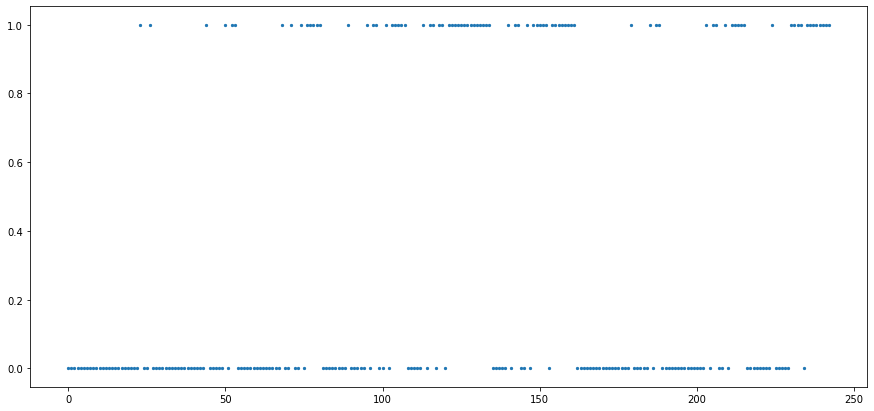

In [23]:
plt.figure(figsize=(15, 7))
plt.scatter(range(reward_list.shape[0]), reward_list, s=5)
plt.show()

In [21]:
reward_list[reward_list!=0]

<tf.Tensor: id=430, shape=(98,), dtype=float32, numpy=
array([2.9802322e-08, 2.9802322e-08, 1.0000000e+00, 1.1920929e-07,
       1.0000000e+00, 9.9999905e-01, 9.9999976e-01, 9.9999988e-01,
       1.0000000e+00, 2.9802322e-08, 1.0000000e+00, 1.1920929e-07,
       1.0000000e+00, 8.9406967e-08, 1.0000000e+00, 1.0000000e+00,
       1.0000000e+00, 9.9999976e-01, 1.0000000e+00, 1.0000000e+00,
       9.9999988e-01, 9.9999988e-01, 9.9999988e-01, 1.0000000e+00,
       1.0000000e+00, 9.9999988e-01, 1.0000000e+00, 9.9999988e-01,
       1.0000000e+00, 1.0000000e+00, 8.9406967e-08, 1.0000000e+00,
       9.9999988e-01, 1.0000000e+00, 9.9999785e-01, 1.0000000e+00,
       1.0000000e+00, 1.0000000e+00, 9.9999988e-01, 1.0000000e+00,
       1.0000000e+00, 1.0000000e+00, 1.0000000e+00, 1.0000000e+00,
       1.0000000e+00, 1.0000000e+00, 1.0000000e+00, 1.0000000e+00,
       1.0000000e+00, 1.0000000e+00, 9.9999988e-01, 1.0000000e+00,
       1.0000000e+00, 9.9999988e-01, 1.0000000e+00, 1.0000000e+00,
       

In [25]:
actor_model = tf.keras.models.load_model('static/target_net_epoch99.h5')

In [26]:
action_list = actor_model(feature_matrix)

In [31]:
action = np.argmax(action_list, axis=1)
action

array([1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,
       1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,
       1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,
       1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,
       1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,
       1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,
       1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,
       1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,
       1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,
       1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,
       1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,
       1], dtype=int64)